# 特徴量作成 3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import calendar
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from collections import deque

In [3]:
import utils

In [4]:
import sys
sys.path.append("../common")
import common_utils

In [5]:
IN_DIRECTORY = '../data/processed'
# OUT_DIRECTORY = './processed'

## 準備

In [6]:
symbol = "usdjpy"
# year_from = 2019
year_from = 2020
# month_from = 10
month_from = 1
# year_to = 2019
year_to = 2020
month_to = 12
# month_to = 3

In [7]:
df_org = utils.read_processed_data_range(symbol, year_from, month_from, year_to, month_to)

In [8]:
assert (df_org.index[0].hour, df_org.index[0].minute) == (0, 0)
assert (df_org.index[-1].hour, df_org.index[-1].minute) == (23, 59)

In [9]:
df_org.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
timestamp,,,,,,,,
2020-01-02 00:00:00,108.730,108.730,108.728,108.728,108.786,108.791,108.786,108.790
2020-01-02 00:01:00,108.728,108.730,108.715,108.715,108.786,108.790,108.784,108.784
2020-01-02 00:02:00,108.719,108.724,108.719,108.724,108.780,108.783,108.780,108.783
2020-01-02 00:03:00,108.724,108.725,108.724,108.725,108.784,108.786,108.783,108.786
2020-01-02 00:04:00,108.725,108.751,108.725,108.751,108.790,108.790,108.776,108.779


In [10]:
df_org.tail()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
timestamp,,,,,,,,
2020-12-31 23:55:00,103.289,103.300,103.288,103.297,103.298,103.308,103.297,103.306
2020-12-31 23:56:00,103.297,103.298,103.293,103.298,103.308,103.308,103.304,103.306
2020-12-31 23:57:00,103.296,103.298,103.294,103.298,103.302,103.308,103.302,103.307
2020-12-31 23:58:00,103.298,103.302,103.296,103.301,103.306,103.309,103.302,103.308
2020-12-31 23:59:00,103.303,103.313,103.208,103.259,103.313,103.326,103.298,103.310


In [11]:
df = pd.DataFrame({
    "open": (df_org["bid_open"] + df_org["ask_open"]) / 2,
    "high": (df_org["bid_high"] + df_org["ask_high"]) / 2,
    "low": (df_org["bid_low"] + df_org["ask_low"]) / 2,
    "close": (df_org["bid_close"] + df_org["ask_close"]) / 2,
}, index=df_org.index)

In [12]:
df = df.add_suffix("_1min")

In [13]:
df.head()

,open_1min,high_1min,low_1min,close_1min
timestamp,,,,
2020-01-02 00:00:00,108.7580,108.7605,108.7570,108.7590
2020-01-02 00:01:00,108.7570,108.7600,108.7495,108.7495
2020-01-02 00:02:00,108.7495,108.7535,108.7495,108.7535
2020-01-02 00:03:00,108.7540,108.7555,108.7535,108.7555
2020-01-02 00:04:00,108.7575,108.7705,108.7505,108.7650


## ラベル作成

In [14]:
# この値以上に上昇するならエントリーする
# thresh_entry = 0.1
thresh_entry = 0.05
# thresh_entry = 0.02

# この値を以下の下落であれば持ち続ける
# thresh_hold = 0.05
thresh_hold = 0.025
# thresh_hold = 0.01

# この値以上に上昇しないなら決済する
thresh_exit = 0.0 #0.005

In [15]:
def compute_entry_idxs(values: np.ndarray, thresh_entry: float, thresh_hold: float):
    # それ以降で走査した中で最大のインデックス
    max_idxs = deque()
    checked_count = 0
    entry_idxs = []
    gains = []
    for i in range(len(values)):
        # より大きい値が後で見つかった場合には、古いインデックスを削除する
        while len(max_idxs) > 0 and values[max_idxs[-1]] < values[i]:
            max_idxs.pop()
        max_idxs.append(i)

        max_value = values[max_idxs[0]]
        # 最大値からしきい値を超えて下落したときに買い時を探す
        if max_value - values[i] > thresh_hold:
            # それ以降で走査した中で最小のインデックス
            min_idxs = deque()
            for j in range(checked_count, max_idxs[0]):
                while len(min_idxs) > 0 and values[min_idxs[-1]] > values[j]:
                    min_idxs.pop()
                min_idxs.append(j)

                gains.append(max_value - values[j])

            while len(min_idxs) > 0:
                min_value = values[min_idxs[0]]
                if max_value - min_value >= thresh_entry:
                    entry_idxs.append(min_idxs[0])
                min_idxs.popleft()

            checked_count = max_idxs[0]
            max_idxs.popleft()

    for j in range(checked_count, len(values)):
        gains.append(np.nan)

    return np.array(entry_idxs), np.array(gains)

In [16]:
long_entry_idxs_high, long_gains_high = compute_entry_idxs(df["high_1min"].values, thresh_entry, thresh_hold)
long_entry_idxs_low, long_gains_low = compute_entry_idxs(df["low_1min"].values, thresh_entry, thresh_hold)

In [17]:
long_entry_high = np.zeros(len(df), dtype=bool)
long_entry_low = np.zeros(len(df), dtype=bool)
long_entry_high[long_entry_idxs_high] = True
long_entry_low[long_entry_idxs_low] = True
df["long_entry"] = long_entry_high & long_entry_low
df["long_exit"] = (long_gains_high < thresh_exit) | (long_gains_low < thresh_exit)

In [18]:
short_entry_idxs_high, short_gains_high = compute_entry_idxs(-df["high_1min"].values, thresh_entry, thresh_hold)
short_entry_idxs_low, short_gains_low = compute_entry_idxs(-df["low_1min"].values, thresh_entry, thresh_hold)

In [19]:
short_entry_high = np.zeros(len(df), dtype=bool)
short_entry_low = np.zeros(len(df), dtype=bool)
short_entry_high[short_entry_idxs_high] = True
short_entry_low[short_entry_idxs_low] = True
df["short_entry"] = short_entry_high & short_entry_low
df["short_exit"] = (short_gains_high < thresh_exit) | (short_gains_low < thresh_exit)

In [20]:
df[["long_entry", "short_entry", "long_exit", "short_exit"]].mean()

long_entry     0.064856
short_entry    0.066552
long_exit      0.181096
short_exit     0.177109
dtype: float64

In [21]:
assert not (df["long_entry"] & df["long_exit"]).any()
assert not (df["short_entry"] & df["short_exit"]).any()

In [22]:
(df["long_exit"] & df["short_exit"]).mean()

0.0006746666666666666

## 実績シミュレーション

In [23]:
loss_cut_threshold = 0.05
start_hour = 2
end_hour = 22

In [33]:
order_manager = common_utils.OrderManager()

for i in range(len(df)):
    timestamp = df.index[i]
    is_open = (
        start_hour <= timestamp.hour < end_hour and
        (timestamp.month, timestamp.day) != (12, 25)
    )
    is_closing = (timestamp.hour == end_hour - 1) and (timestamp.minute == 59)

    if not is_open:
        continue

    if order_manager.has_position():
        # 厳し目の見積もりをする
        current_rate_long = df["low_1min"][i]
        current_rate_short = df["high_1min"][i]
        # current_rate_long = df["open_1min"][i]
        # current_rate_short = df["open_1min"][i]

        open_position = order_manager.open_position
        loss_cut_long = open_position.entry_rate - current_rate_long > loss_cut_threshold
        loss_cut_short = current_rate_short - open_position.entry_rate > loss_cut_threshold

        if open_position.position_type == "long" and (df["long_exit"][i] or is_closing or loss_cut_long):
            order_manager.exit("long", timestamp, current_rate_long)
            # print(timestamp, "long exit")
        elif open_position.position_type == "short" and (df["short_exit"][i] or is_closing or loss_cut_short):
            order_manager.exit("short", timestamp, current_rate_short)
            # print(timestamp, "short exit")

    if not is_closing and not order_manager.has_position():
        # 厳し目の見積もりをする
        current_rate_long = df["high_1min"][i]
        current_rate_short = df["low_1min"][i]
        # current_rate_long = df["open_1min"][i]
        # current_rate_short = df["open_1min"][i]

        if df["long_entry"][i]:
            order_manager.entry("long", timestamp, current_rate_long)
            # print(timestamp, "long entry")
        elif df["short_entry"][i]:
            order_manager.entry("short", timestamp, current_rate_short)
            # print(timestamp, "short entry")

In [34]:
days = (df.index[-1] - df.index[0]).days * (5/7)
months = int(np.round((df.index[-1] - df.index[0]).days / 30))
print(f"days = {days}")
print(f"総オーダー数: {len(order_manager.order_history)}")
print(f"1日あたりの平均オーダー数: {len(order_manager.order_history) / days}")

days = 260.0
総オーダー数: 10178
1日あたりの平均オーダー数: 39.146153846153844


### 利得

In [35]:
spread = 0.01
profits = []
for order in order_manager.order_history:
    if order.position_type == "long":
        profits.append(order.exit_rate - order.entry_rate)
    elif order.position_type == "short":
        profits.append(order.entry_rate - order.exit_rate)
profits = np.array(profits) - spread

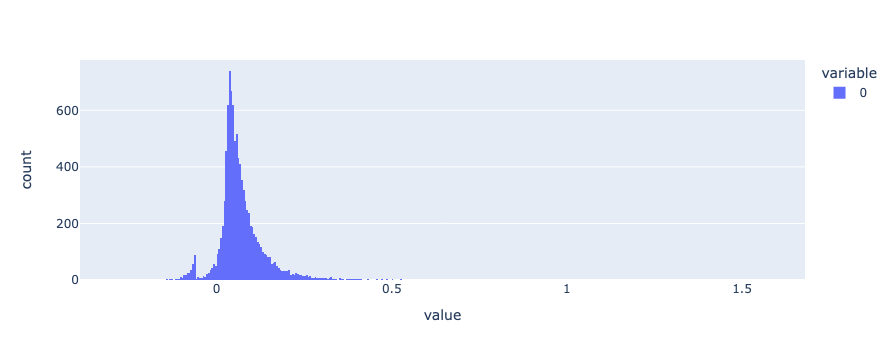

In [36]:
px.histogram(profits)

In [37]:
profits.mean(), profits.sum() / months

(0.06940278050697597, 58.86512500000012)

In [123]:
profits.mean(), profits.sum() / months

(0.068428381962865, 40.84604166666684)

In [38]:
profits.min()

-0.38749999999999774

In [39]:
order = order_manager.order_history[profits.argmin()]

In [40]:
order.position_type, order.entry_timestamp, order.exit_timestamp

('short', Timestamp('2020-03-09 04:51:00'), Timestamp('2020-03-09 04:52:00'))

In [41]:
df.loc[order.entry_timestamp:order.exit_timestamp]

,open_1min,high_1min,low_1min,close_1min,long_entry,long_exit,short_entry,short_exit
timestamp,,,,,,,,
2020-03-09 04:51:00,102.1475,102.688,102.0695,102.4355,False,True,True,False
2020-03-09 04:52:00,102.4395,102.447,101.5775,102.2090,False,True,False,True


なぜ損失が出ている?  
-> high, low それぞれは正しい方向に推移しているが, それらの差が大きいため, 厳しい見積もりをすると損することになる

### 決済までの時間

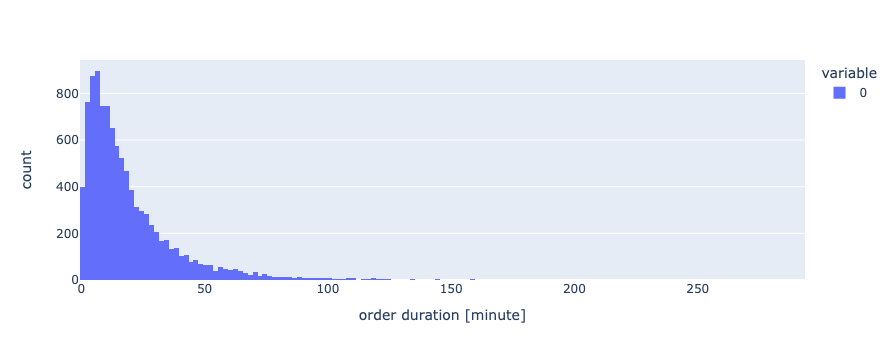

In [42]:
timedeltas = pd.Series([order.exit_timestamp - order.entry_timestamp for order in order_manager.order_history])
fig = px.histogram(timedeltas.dt.seconds // 60)
fig.update_layout(xaxis_title="order duration [minute]")

In [43]:
timedeltas.min(), timedeltas.median(), timedeltas.mean(), timedeltas.max()

(Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:14:00'),
 Timedelta('0 days 00:19:48.923167616'),
 Timedelta('0 days 04:53:00'))

In [44]:
order = order_manager.order_history[timedeltas.argmax()]
order.entry_timestamp, order.exit_timestamp

(Timestamp('2020-01-16 05:39:00'), Timestamp('2020-01-16 10:32:00'))

### 取引の可視化

In [61]:
# plot_date = "2019-10-02"
# plot_date = "2019-08-15"
plot_date = "2020-08-18"
start_datetime = pd.Timestamp(plot_date + " 00:00:00")
end_datetime = pd.Timestamp(plot_date + " 23:59:59")

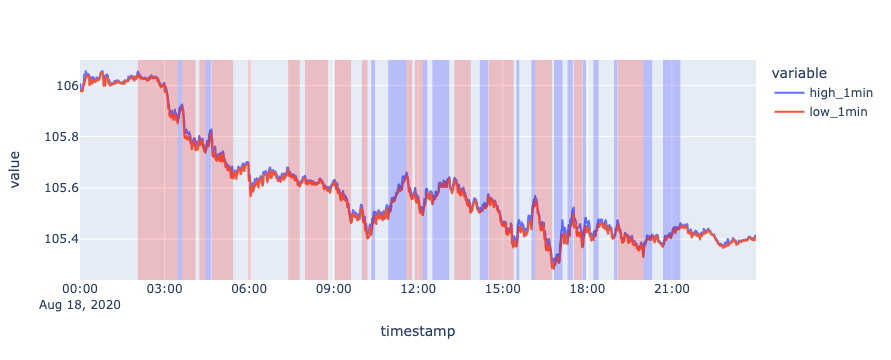

In [46]:

fig = px.line(df.loc[plot_date, ["high_1min", "low_1min"]])

for order in order_manager.order_history:
    if order.entry_timestamp < start_datetime or order.exit_timestamp > end_datetime:
        continue

    fillcolor = "blue" if order.position_type == "long" else "red"
    fig.add_vrect(x0=order.entry_timestamp, x1=order.exit_timestamp, line_width=0, opacity=0.2, fillcolor=fillcolor)

fig.show()

In [69]:
end_datetime = pd.Timestamp(plot_date + " 10:12:59")

In [72]:
gain_sum = 0
for order in order_manager.order_history:
    if order.entry_timestamp < start_datetime or order.exit_timestamp > end_datetime:
        continue
    gain_sum += order.gain
    print(order.entry_timestamp, order.exit_timestamp, order.position_type, order.gain)

2020-08-18 02:03:00 2020-08-18 03:28:00 short 0.1740000000000066
2020-08-18 03:28:00 2020-08-18 03:37:00 long 0.05000000000001137
2020-08-18 03:37:00 2020-08-18 04:06:00 short 0.1560000000000059
2020-08-18 04:14:00 2020-08-18 04:27:00 short 0.041500000000013415
2020-08-18 04:27:00 2020-08-18 04:39:00 long 0.0660000000000025
2020-08-18 04:40:00 2020-08-18 05:26:00 short 0.13750000000001705
2020-08-18 05:58:00 2020-08-18 06:03:00 short 0.08500000000000796
2020-08-18 07:23:00 2020-08-18 07:48:00 short 0.06099999999999284
2020-08-18 07:59:00 2020-08-18 08:48:00 short 0.043000000000006366
2020-08-18 09:02:00 2020-08-18 09:37:00 short 0.14300000000000068
2020-08-18 10:00:00 2020-08-18 10:12:00 short 0.08650000000000091


In [73]:
gain_sum

1.0435000000000656